In [1]:
from abc import abstractmethod, ABC
import torch
import gpytorch
from torchdiffeq import odeint
import numpy as np
import sys 
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from matplotlib import pyplot as plt
from alfi.configuration import VariationalConfiguration
from alfi.utilities.torch import is_cuda
from alfi.models.lfm import LFM
from alfi.mlls import MaskedVariationalELBO
from alfi.plot import Plotter1d, plot_phase, Colours
from alfi.utilities.torch import softplus, inv_softplus
from torch.nn.parameter import Parameter
from gpytorch.models import ApproximateGP
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from gpytorch.constraints import Positive, Interval
from data.generator import PVDataGenerator
from data.utils import *
from data.lfm_dataset import PV_LFM_Dataset

In [2]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)
IDX = 6
NUM_OUTPUTS = 1
NUM_LATENTS = 1
NUM_INDUCING = 100

In [3]:
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

X, y = generator.get_time_series()

x_train, y_train, x_test, y_test = train_test_split(X, y, n_hours=N_HOURS_PRED)

x_train[:,1] *= y_train[:,:NUM_OUTPUTS].max()
x_test[:,1] *= y_test[:,:NUM_OUTPUTS].max()

==> Loading data
==> Loaded data in: 0 m : 9 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [5]:
t_train = torch.linspace(0, 10, len(y_train))

In [6]:
dataset = PV_LFM_Dataset(num_outputs=NUM_OUTPUTS, 
                         m_observed=y_train[:, :NUM_OUTPUTS],
                         f_observed=x_train[:,1], 
                         train_t=t_train,
                         variance= 0.01 * torch.ones(NUM_OUTPUTS, dtype=torch.float64))

In [7]:
x_min, x_max = dataset.t_observed.min(), dataset.t_observed.max()
num_training = len(dataset.t_observed)

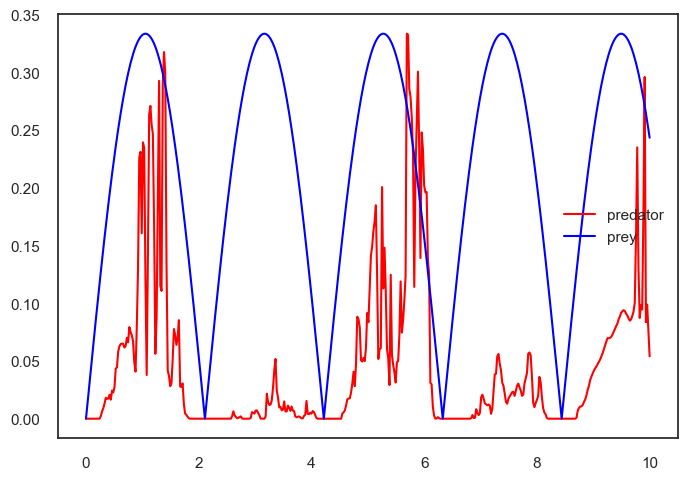

In [28]:
plt.rcParams['font.family'] = 'Arial'

plt.plot(dataset.data[0][0], dataset.data[0][1], c='red', label='predator')
plt.plot(torch.linspace(x_min, x_max, dataset.f_observed.shape[-1]), dataset.f_observed[0,0,:], c='blue', label='prey')
plt.legend()
output_names = dataset.names

In [9]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import (
    NaturalVariationalDistribution,
    CholeskyVariationalDistribution,
    VariationalStrategy,
    IndependentMultitaskVariationalStrategy,
    TrilNaturalVariationalDistribution
)

class MultiOutputGP(ApproximateGP):
    def __init__(self,
                 mean_module,
                 covar_module,
                 inducing_points,
                 num_latents,
                 learn_inducing_locations=False,
                 natural=True,
                 use_tril=False):
        # The variational dist batch shape means we learn a different variational dist for each latent
        if natural:
            Distribution = TrilNaturalVariationalDistribution if use_tril else NaturalVariationalDistribution
            variational_distribution = Distribution(
                inducing_points.size(-2), batch_shape=torch.Size([num_latents])
            )
        else:
            variational_distribution = CholeskyVariationalDistribution(
                inducing_points.size(-2), batch_shape=torch.Size([num_latents])
            )

        # Wrap the VariationalStrategy in a MultiTask to make output MultitaskMultivariateNormal
        # rather than a batch MVN
        variational_strategy = IndependentMultitaskVariationalStrategy(
            VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=learn_inducing_locations
            ), num_tasks=num_latents
        )
        super().__init__(variational_strategy)

        self.mean_module = mean_module
        self.covar_module = covar_module

    def get_inducing_points(self):
        return self.variational_strategy.base_variational_strategy.inducing_points

    def forward(self, t):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(t)
        covar_x = self.covar_module(t)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def generate_multioutput_rbf_gp(num_latents, inducing_points,
                                ard_dims=None,
                                use_scale=False,
                                initial_lengthscale=None,
                                lengthscale_constraint=None,
                                zero_mean=True,
                                gp_kwargs={}):
    # Modules should be marked as batch so different set of hyperparameters are learnt
    if zero_mean:
        mean_module = gpytorch.means.ZeroMean(batch_shape=torch.Size([num_latents]))
    else:
        mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
    covar_module = gpytorch.kernels.RBFKernel(
        batch_shape=torch.Size([num_latents]),
        ard_num_dims=ard_dims,
        lengthscale_constraint=lengthscale_constraint
    )
    if use_scale:
        covar_module = gpytorch.kernels.ScaleKernel(
            covar_module,
            batch_shape=torch.Size([num_latents])
        )
    if initial_lengthscale is not None:
        if use_scale:
            covar_module.base_kernel.lengthscale = initial_lengthscale
        else:
            covar_module.lengthscale = initial_lengthscale
    return MultiOutputGP(mean_module, covar_module, inducing_points, num_latents, **gp_kwargs)

In [10]:
class VariationalLFM(LFM, ABC):
    """
    Variational inducing point approximation for Latent Force Models.

    Parameters
    ----------
    num_outputs : int : the number of outputs (for example, the number of genes)
    fixed_variance : tensor : variance if the preprocessing variance is known, otherwise learnt.
    """
    def __init__(self,
                 num_outputs: int,
                 gp_model: ApproximateGP,
                 config: VariationalConfiguration,
                 num_training_points=None,
                 dtype=torch.float64):
        super().__init__()
        self.gp_model = gp_model
        self.num_outputs = num_outputs
        self.likelihood = MultitaskGaussianLikelihood(num_tasks=self.num_outputs)
        self.pretrain_mode = False
        try:
            self.inducing_points = self.gp_model.get_inducing_points()
        except AttributeError:
            raise AttributeError('The GP model must define a function `get_inducing_points`.')

        if num_training_points is None:
            num_training_points = self.inducing_points.numel()  # TODO num_data refers to the number of training datapoints

        self.loss_fn = MaskedVariationalELBO(self.likelihood, gp_model, num_training_points, combine_terms=False)
        self.config = config
        self.dtype = dtype

        # if config.preprocessing_variance is not None:
        #     self.likelihood_variance = Parameter(torch.tensor(config.preprocessing_variance), requires_grad=False)
        # else:
        #     self.raw_likelihood_variance = Parameter(torch.ones((self.num_outputs, self.num_observed), dtype=dtype))

        if config.initial_conditions:
            self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)

    def nonvariational_parameters(self):
        variational_keys = dict(self.gp_model.named_variational_parameters()).keys()
        named_parameters = dict(self.named_parameters())
        return [named_parameters[key] for key in named_parameters.keys()
                if key[len('gp_model.'):] not in variational_keys]

    def variational_parameters(self):
        return self.gp_model.variational_parameters()

    def summarise_gp_hyp(self):
        # variational_keys = dict(self.gp_model.named_variational_parameters()).keys()
        # named_parameters = dict(self.named_parameters())
        #
        # return [named_parameters[key] for key in named_parameters.keys()
        #         if key[len('gp_model.'):] not in variational_keys]
        if self.gp_model.covar_module.lengthscale is not None:
            return self.gp_model.covar_module.lengthscale.detach().cpu().numpy()
        elif hasattr(self.gp_model.covar_module, 'base_kernel'):
            kernel = self.gp_model.covar_module.base_kernel
            if hasattr(kernel, 'kernels'):
                if hasattr(kernel.kernels[0], 'lengthscale'):
                    return kernel.kernels[0].lengthscale.detach().cpu().numpy()
            else:
                return self.gp_model.covar_module.base_kernel.lengthscale.detach().cpu().numpy()
        else:
            return ''

    def forward(self, x):
        raise NotImplementedError

    def train(self, mode: bool = True):
        self.gp_model.train(mode)
        self.likelihood.train(mode)

    def pretrain(self, mode=True):
        self.pretrain_mode = mode

    def eval(self):
        self.gp_model.eval()
        self.likelihood.eval()
        self.pretrain(False)

    def predict_m(self, t_predict, **kwargs) -> torch.distributions.MultivariateNormal:
        """
        Calls self on input `t_predict`
        """
        return self(t_predict.view(-1), **kwargs)

    def predict_f(self, t_predict, **kwargs) -> torch.distributions.MultivariateNormal:
        """
        Returns the latents
        """
        self.eval()
        with torch.no_grad():
            q_f = self.gp_model(t_predict)
        self.train()
        return q_f

    def save(self, filepath):
        torch.save(self.gp_model.state_dict(), str(filepath)+'gp.pt')
        torch.save(self.state_dict(), str(filepath)+'lfm.pt')

    @classmethod
    def load(cls,
             filepath,
             gp_cls=None, gp_model=None,
             gp_args=[], gp_kwargs={},
             lfm_args=[], lfm_kwargs={}):
        assert not (gp_cls is None and (gp_model is None))
        gp_state_dict = torch.load(filepath+'gp.pt')
        if gp_cls is not None:
            gp_model = gp_cls(*gp_args, **gp_kwargs)
        gp_model.load_state_dict(gp_state_dict)
        gp_model.double()

        lfm_state_dict = torch.load(filepath+'lfm.pt')
        lfm = cls(lfm_args[0], gp_model, *lfm_args[1:], **lfm_kwargs)
        lfm.load_state_dict(lfm_state_dict)
        return lfm

In [11]:
class OrdinaryLFM(VariationalLFM):
    """
    Variational approximation for an LFM based on an ordinary differential equation (ODE).
    Inheriting classes must override the `odefunc` function which encodes the ODE.
    """

    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.nfe = 0
        self.f = None

    def initial_state(self):
        initial_state = torch.zeros(torch.Size([self.num_outputs, 1]), dtype=torch.float64)
        initial_state = initial_state.cuda() if is_cuda() else initial_state
        return initial_state #initial_state.repeat(self.config.num_samples, 1, 1)  # Add batch dimension for sampling
        # if self.config.initial_conditions: TODO:
        #     h = self.initial_conditions.repeat(h.shape[0], 1, 1)

    def forward(self, t, step_size=1e-1, return_samples=False, **kwargs):
        """
        t : torch.Tensor
            Shape (num_times)
        h : torch.Tensor the initial state of the ODE
            Shape (num_genes, 1)
        Returns
        -------
        Returns evolved h across times t.
        Shape (num_genes, num_points).
        """
        self.nfe = 0

        # Get GP outputs
        if self.pretrain_mode:
            t_f = t[0]
            h0 = t[1]
        else:
            t_f = torch.arange(t.min(), t.max()+ 2*step_size/3, step_size/3)
            h0 = self.initial_state()
            h0 = h0.unsqueeze(0).repeat(self.config.num_samples, 1, 1)

        q_f = self.gp_model(t_f)

        self.f = q_f.rsample(torch.Size([self.config.num_samples])).permute(0, 2, 1)  # (S, I, T)
        self.f = self.G(self.f)

        if self.pretrain_mode:
            h_samples = self.odefunc(t_f, h0)
            h_samples = h_samples.permute(2, 0, 1)
        else:
            # Integrate forward from the initial positions h0.
            self.t_index = 0
            self.last_t = self.f.min() - 1
            h_samples = odeint(self.odefunc, h0, t, method='rk4', options=dict(step_size=step_size)) # (T, S, num_outputs, 1)

        self.f = None
        # self.t_index = None
        # self.last_t = None
        if return_samples:
            return h_samples

        h_mean = torch.mean(h_samples, dim=1).squeeze(-1).transpose(0, 1)  # shape was (#outputs, #T, 1)
        h_var = torch.var(h_samples, dim=1).squeeze(-1).transpose(0, 1) + 1e-7
        h_mean = self.decode(h_mean)
        h_var = self.decode(h_var)
        # TODO: make distribution something less constraining
        h_covar = torch.diag_embed(h_var) + torch.eye(self.num_outputs, dtype=torch.float64) * 1e-1
        batch_mvn = gpytorch.distributions.MultivariateNormal(h_mean, h_covar)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(batch_mvn, task_dim=0)

    def decode(self, h_out):
        return h_out

    @abstractmethod
    def odefunc(self, t, h):
        """
        Parameters:
            h: shape (num_samples, num_outputs, 1)
        """
        pass

    def G(self, f):
        return f.repeat(1, self.num_outputs, 1)  # (S, I, t)

In [29]:
class LotkaVolterra(OrdinaryLFM):
    """Outputs are predator. Latents are prey"""
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.num_tasks = num_outputs
        self.positivity = Positive()
        self.decay_constraint = Interval(0., 100.)
        self.raw_decay = Parameter(self.decay_constraint.inverse_transform(torch.ones(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_growth = Parameter(self.positivity.inverse_transform(0.5*torch.ones(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_initial = Parameter(self.positivity.inverse_transform(0.3+torch.zeros(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))

    @property
    def decay_rate(self):
        return self.decay_constraint.transform(self.raw_decay)

    @decay_rate.setter
    def decay_rate(self, value):
        self.raw_decay = self.decay_constraint.inverse_transform(value)

    @property
    def growth_rate(self):
        return softplus(self.raw_growth)

    @growth_rate.setter
    def growth_rate(self, value):
        self.raw_growth = inv_softplus(value)

    @property
    def initial_predators(self):
        return softplus(self.raw_initial)

    @initial_predators.setter
    def initial_predators(self, value):
        self.raw_initial = inv_softplus(value)

    def initial_state(self):
        return self.initial_predators

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        
        f = self.G(self.f[:, :, self.t_index].unsqueeze(2))
        dh = self.growth_rate * h * f - self.decay_rate * h
        
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t
        
        return dh

    def G(self, f):
        # I = 1 so just repeat for num_outputs
        #softplus
        return softplus(f).repeat(1, self.num_outputs, 1)

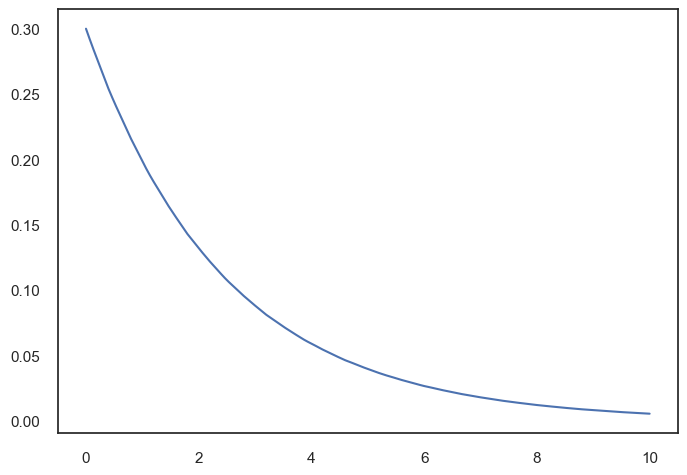

In [32]:
use_natural = False
config = VariationalConfiguration(num_samples=70)
inducing_points = torch.linspace(x_min, x_max, NUM_INDUCING).repeat(NUM_LATENTS, 1).view(
    NUM_LATENTS, NUM_INDUCING, 1)
t_predict = torch.linspace(0, x_max, 151, dtype=torch.float32)

# TODO change kernel

periodic = True
mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([NUM_LATENTS]))

track_parameters = ['raw_growth', 'raw_decay']

covar_module = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(batch_shape=torch.Size([NUM_LATENTS])),
    batch_shape=torch.Size([NUM_LATENTS])
) 
covar_module.base_kernel.lengthscale = 0.1
# covar_module.base_kernel.period_length = 0.5
track_parameters.append('gp_model.covar_module.base_kernel.raw_lengthscale')


gp_model = MultiOutputGP(mean_module, covar_module,
                         inducing_points, NUM_LATENTS,
                         natural=use_natural)


lfm = LotkaVolterra(NUM_OUTPUTS, gp_model, config, num_training_points=num_training)

plotter = Plotter1d(lfm, np.array(['predator']))
plt.rcParams['font.family'] = 'Arial'

out = lfm(t_predict, step_size=1e-1)
plt.plot(t_predict, out.mean.detach())

In [20]:
from lfm_trainer import VariationalTrainer
optimizer = [torch.optim.Adam(lfm.parameters(), lr=0.02)]

trainer = VariationalTrainer(
    lfm,
    optimizer,
    dataset,
    warm_variational=100,
    track_parameters=track_parameters,
    step_size=1/3
)

In [21]:
a = trainer.train(200, report_interval=10, step_size=3)

Epoch 0 - Loss: 511.88 - ll: -511.88 - kl: 0.00
Epoch 001/200 - Loss: 511.88 0.00kernel: [[[0.09811388]]]
Epoch 011/200 - Loss: 480.52 0.00kernel: [[[0.09034107]]]
Epoch 021/200 - Loss: 448.58 0.01kernel: [[[0.08726265]]]
Epoch 031/200 - Loss: 415.91 0.00kernel: [[[0.08454894]]]
Epoch 041/200 - Loss: 382.77 0.00kernel: [[[0.08173751]]]
Epoch 051/200 - Loss: 349.57 0.01kernel: [[[0.07909527]]]
Epoch 061/200 - Loss: 316.87 0.00kernel: [[[0.0768052]]]
Epoch 071/200 - Loss: 285.28 0.00kernel: [[[0.07380841]]]
Epoch 081/200 - Loss: 255.48 0.00kernel: [[[0.06866144]]]
Epoch 091/200 - Loss: 227.88 0.02kernel: [[[0.05334818]]]
Epoch 100 - Loss: 203.46 - ll: -203.43 - kl: 0.03
Epoch 101/200 - Loss: 203.46 0.03kernel: [[[0.05216882]]]
Epoch 111/200 - Loss: 182.65 0.04kernel: [[[0.06043763]]]
Epoch 121/200 - Loss: 165.97 0.08kernel: [[[0.06701068]]]
Epoch 131/200 - Loss: 153.33 0.07kernel: [[[0.07275412]]]
Epoch 141/200 - Loss: 144.46 0.05kernel: [[[0.07786535]]]
Epoch 151/200 - Loss: 138.85 0.04

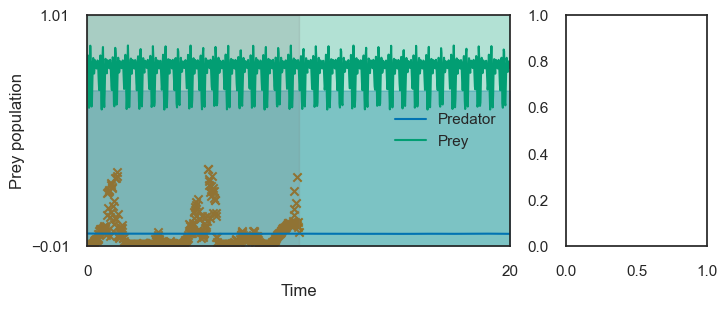

In [27]:
lfm.eval()
t_interval = (0, 20)
t_predict = torch.linspace(*t_interval, 1000, dtype=torch.float32)
t_scatter = dataset.data[0][0].unsqueeze(0).unsqueeze(0)
y_scatter = dataset.data[0][1].unsqueeze(0).unsqueeze(0)

q_m = lfm.predict_m(t_predict, step_size=5e-1)
q_f = lfm.predict_f(t_predict)
ylim = (-0.01, 1.01)

plt.rcParams['font.family'] = 'Arial'
fig, axes = plt.subplots(ncols=2,
                         figsize=(8, 3),
                         gridspec_kw=dict(width_ratios=[3, 1]))
plotter.plot_gp(q_m, t_predict, num_samples=0,
                t_scatter=t_scatter,
                y_scatter=y_scatter,
                ylim=ylim,
                titles=None, ax=axes[0])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Population')
axes[0].set_xlim(*t_interval)
# axes[0].legend()

plotter.plot_gp(q_f, t_predict,
                transform=softplus,
                color=Colours.line2_color,
                shade_color=Colours.shade2_color,
                ylim=ylim,
                titles=None, ax=axes[0])

axes[0].set_xlabel('Time')
axes[0].set_ylabel('Prey population')
axes[0].set_xticks([t_predict[0], t_predict[-1]])
# axes[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2, integer=True))
axes[0].set_yticks([ylim[0], ylim[1]])
axes[0].fill_between(t_scatter.squeeze(), ylim[0], ylim[1], alpha=0.2, color='gray')
axes[0].get_lines()[0].set_label('Predator')
axes[0].get_lines()[1].set_label('Prey')
axes[0].legend()
